# 45. e5-base fastembed互換性検証

## 目的
- fastembed で multilingual-e5-base が使えるか確認
- sentence-transformers e5-base で学習したITQをfastembedに適用
- ITQ再学習の必要性を評価
- 正規化の違いによる影響を分析

## 背景
- 実験42結果: fastembed E5-large は ITQ再学習なしで 99.9% Recall
- fastembed E5-large の平均ベクトル norm = 24.3431 (正規化なし)
- sentence-transformers E5-large の平均ベクトル norm = 0.8736

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from tqdm import tqdm
import time
import gc

from fastembed import TextEmbedding
from sentence_transformers import SentenceTransformer
from src.itq_lsh import ITQLSH

print('Setup complete')

Setup complete


In [3]:
# 定数設定
DB_PATH = '../data/experiment_400k.duckdb'
N_SAMPLES = 2000
N_BITS = 96  # e5-base用
CANDIDATE_SIZES = [100, 200, 500, 1000, 2000]
TOP_K = 10
N_QUERIES = 100
SEED = 42

## 1. fastembedモデル確認

In [4]:
# fastembedでサポートされているモデルを確認
supported_models = TextEmbedding.list_supported_models()
df_models = pd.DataFrame(supported_models)

print(f'サポートモデル総数: {len(df_models)}')
print()

# e5関連モデルをフィルタ
e5_models = df_models[df_models['model'].str.contains('e5', case=False)]
print('=== E5関連モデル ===')
if len(e5_models) > 0:
    display(e5_models[['model', 'dim', 'size_in_GB', 'description']])
else:
    print('E5モデルが見つかりません')

サポートモデル総数: 30

=== E5関連モデル ===


,model,dim,size_in_GB,description
28,intfloat/multilingual-e5-large,1024,2.24,"Text embeddings, Unimodal (text), Multilingual..."


In [5]:
# e5-base の存在確認
e5_base_models = df_models[df_models['model'].str.contains('e5-base', case=False)]

if len(e5_base_models) > 0:
    print('✓ fastembedでe5-baseが利用可能')
    FE_MODEL_NAME = e5_base_models.iloc[0]['model']
    FE_MODEL_DIM = e5_base_models.iloc[0]['dim']
    print(f'  モデル名: {FE_MODEL_NAME}')
    print(f'  次元数: {FE_MODEL_DIM}')
else:
    print('✗ fastembedにe5-baseがありません')
    print('  代替として768次元モデルを探します...')
    
    # 768次元モデルを探す
    dim_768_models = df_models[df_models['dim'] == 768]
    if len(dim_768_models) > 0:
        print('  768次元モデル:')
        display(dim_768_models[['model', 'dim', 'size_in_GB']])
        FE_MODEL_NAME = dim_768_models.iloc[0]['model']
        FE_MODEL_DIM = 768
    else:
        print('  768次元モデルもありません。E5-largeを使用します。')
        FE_MODEL_NAME = 'intfloat/multilingual-e5-large'
        FE_MODEL_DIM = 1024

ST_MODEL_NAME = 'intfloat/multilingual-e5-base'
ST_MODEL_DIM = 768

✗ fastembedにe5-baseがありません
  代替として768次元モデルを探します...
  768次元モデル:


,model,dim,size_in_GB
0,BAAI/bge-base-en,768,0.42
1,BAAI/bge-base-en-v1.5,768,0.21
9,snowflake/snowflake-arctic-embed-m,768,0.43
10,snowflake/snowflake-arctic-embed-m-long,768,0.54
12,jinaai/jina-clip-v1,768,0.55
15,jinaai/jina-embeddings-v2-base-en,768,0.52
17,jinaai/jina-embeddings-v2-base-de,768,0.32
18,jinaai/jina-embeddings-v2-base-code,768,0.64
19,jinaai/jina-embeddings-v2-base-zh,768,0.64
20,jinaai/jina-embeddings-v2-base-es,768,0.64


## 2. テストデータ準備

In [6]:
# experiment_400kからサンプリング
conn = duckdb.connect(DB_PATH, read_only=True)

df_sample = conn.execute(f'''
    SELECT id, text, lang
    FROM documents
    ORDER BY hash(id + {SEED})
    LIMIT {N_SAMPLES}
''').fetchdf()

texts = df_sample['text'].tolist()

print(f'テストテキスト数: {len(texts)}')
print(f'言語分布:')
print(df_sample['lang'].value_counts())

conn.close()

テストテキスト数: 2000
言語分布:
lang
en    1017
ja     983
Name: count, dtype: int64


## 3. 両ライブラリで埋め込み生成

In [7]:
# sentence-transformers e5-base (GPU)
print(f'sentence-transformers {ST_MODEL_NAME} をロード中...')
st_model = SentenceTransformer(ST_MODEL_NAME, device='cuda')

texts_with_prefix = [f'passage: {t}' for t in texts]

t0 = time.time()
st_embeddings = st_model.encode(
    texts_with_prefix,
    normalize_embeddings=False,
    show_progress_bar=True
).astype(np.float32)
st_time = time.time() - t0

print(f'\nST e5-base: {st_embeddings.shape}')
print(f'  処理時間: {st_time:.2f}秒 ({len(texts)/st_time:.1f} texts/sec)')

del st_model
gc.collect()

sentence-transformers intfloat/multilingual-e5-base をロード中...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]


ST e5-base: (2000, 768)
  処理時間: 3.69秒 (541.8 texts/sec)


56

In [8]:
# fastembed
print(f'fastembed {FE_MODEL_NAME} をロード中...')
fe_model = TextEmbedding(FE_MODEL_NAME)

t0 = time.time()
fe_embeddings = np.array(list(fe_model.embed(texts))).astype(np.float32)
fe_time = time.time() - t0

print(f'\nfastembed: {fe_embeddings.shape}')
print(f'  処理時間: {fe_time:.2f}秒 ({len(texts)/fe_time:.1f} texts/sec)')

fastembed BAAI/bge-base-en をロード中...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


fastembed: (2000, 768)
  処理時間: 464.97秒 (4.3 texts/sec)


## 4. 平均ベクトル比較

In [9]:
# 各埋め込みの統計
print('=' * 60)
print('埋め込みベクトル統計')
print('=' * 60)

embeddings_dict = {
    f'ST {ST_MODEL_NAME.split("/")[-1]}': st_embeddings,
    f'fastembed {FE_MODEL_NAME.split("/")[-1]}': fe_embeddings,
}

stats_data = []
mean_vectors = {}

for name, emb in embeddings_dict.items():
    mean_vec = emb.mean(axis=0)
    mean_vectors[name] = mean_vec
    
    # 各ベクトルのnorm
    norms = norm(emb, axis=1)
    
    stats_data.append({
        'モデル': name,
        '次元': emb.shape[1],
        '平均norm': f'{mean_vec.mean():.4f}',
        '平均ベクトルnorm': f'{norm(mean_vec):.4f}',
        '各ベクトルnorm平均': f'{norms.mean():.4f}',
        '各ベクトルnorm std': f'{norms.std():.4f}',
    })
    
    print(f'\n{name}:')
    print(f'  Shape: {emb.shape}')
    print(f'  平均ベクトル norm: {norm(mean_vec):.4f}')
    print(f'  各ベクトル norm: mean={norms.mean():.4f}, std={norms.std():.4f}')

df_stats = pd.DataFrame(stats_data)
display(df_stats)

埋め込みベクトル統計

ST multilingual-e5-base:
  Shape: (2000, 768)
  平均ベクトル norm: 0.8766
  各ベクトル norm: mean=1.0000, std=0.0000

fastembed bge-base-en:
  Shape: (2000, 768)
  平均ベクトル norm: 0.8734
  各ベクトル norm: mean=1.0000, std=0.0000


,モデル,次元,平均norm,平均ベクトルnorm,各ベクトルnorm平均,各ベクトルnorm std
0,ST multilingual-e5-base,768,-0.0001,0.8766,1.0000,0.0000
1,fastembed bge-base-en,768,-0.0007,0.8734,1.0000,0.0000


In [10]:
# 平均ベクトル間の類似度
names = list(mean_vectors.keys())

if len(names) >= 2 and mean_vectors[names[0]].shape == mean_vectors[names[1]].shape:
    mv1 = mean_vectors[names[0]]
    mv2 = mean_vectors[names[1]]
    cos_sim = np.dot(mv1, mv2) / (norm(mv1) * norm(mv2) + 1e-10)
    print(f'\n平均ベクトル間のコサイン類似度:')
    print(f'  {names[0]} vs {names[1]}: {cos_sim:.4f}')
else:
    print('次元が異なるため、平均ベクトルの直接比較ができません')


平均ベクトル間のコサイン類似度:
  ST multilingual-e5-base vs fastembed bge-base-en: 0.0384


In [11]:
# 同一テキストの埋め込み類似度（次元が同じ場合のみ）
if st_embeddings.shape[1] == fe_embeddings.shape[1]:
    st_norm = st_embeddings / (norm(st_embeddings, axis=1, keepdims=True) + 1e-10)
    fe_norm = fe_embeddings / (norm(fe_embeddings, axis=1, keepdims=True) + 1e-10)
    pairwise_sim = np.sum(st_norm * fe_norm, axis=1)
    
    print(f'\n同一テキストの埋め込み類似度:')
    print(f'  mean: {pairwise_sim.mean():.4f}')
    print(f'  std:  {pairwise_sim.std():.4f}')
    print(f'  min:  {pairwise_sim.min():.4f}')
    print(f'  max:  {pairwise_sim.max():.4f}')
else:
    print('次元が異なるため、同一テキストの類似度比較ができません')
    pairwise_sim = None


同一テキストの埋め込み類似度:
  mean: 0.0292
  std:  0.0211
  min:  -0.0579
  max:  0.1025


## 5. ITQ学習 (sentence-transformers)

In [12]:
# sentence-transformers e5-base用 ITQ学習
print('=' * 60)
print(f'ITQ学習 ({N_BITS} bits) - ST e5-base')
print('=' * 60)

itq_st = ITQLSH(n_bits=N_BITS, n_iterations=50, seed=SEED)
itq_st.fit(st_embeddings)

print(f'\n学習完了:')
print(f'  平均ベクトル norm: {norm(itq_st.mean_vector):.4f}')

ITQ学習 (96 bits) - ST e5-base
ITQ学習開始: samples=2000, dim=768, bits=96
  Centering完了: mean_norm=0.8766
  PCA完了: explained_variance=66.35%
  ITQ iteration 10: quantization_error=0.9339
  ITQ iteration 20: quantization_error=0.9334
  ITQ iteration 30: quantization_error=0.9332
  ITQ iteration 40: quantization_error=0.9331
  ITQ iteration 50: quantization_error=0.9330
ITQ学習完了

学習完了:
  平均ベクトル norm: 0.8766


## 6. ハミング距離関数とRecall評価関数

In [13]:
def hamming_distance_batch(query_hash, candidate_hashes):
    """クエリと候補間のハミング距離を計算"""
    xor_result = np.bitwise_xor(query_hash, candidate_hashes)
    distances = np.sum(np.unpackbits(xor_result, axis=1), axis=1)
    return distances


def evaluate_recall(embeddings, hashes, candidate_sizes, top_k=10, n_queries=100, seed=42):
    """Recall@K を評価"""
    rng = np.random.default_rng(seed)
    n_docs = len(embeddings)
    query_indices = rng.choice(n_docs, min(n_queries, n_docs), replace=False)
    
    results = {k: [] for k in candidate_sizes}
    
    for qi in tqdm(query_indices, desc='Evaluating'):
        query_emb = embeddings[qi]
        cosines = embeddings @ query_emb / (norm(embeddings, axis=1) * norm(query_emb) + 1e-10)
        gt_set = set(np.argsort(cosines)[-top_k:])
        
        query_hash = hashes[qi]
        distances = hamming_distance_batch(query_hash, hashes)
        sorted_indices = np.argsort(distances)
        
        for k in candidate_sizes:
            candidates = sorted_indices[:k]
            cand_cosines = embeddings[candidates] @ query_emb
            cand_cosines = cand_cosines / (norm(embeddings[candidates], axis=1) * norm(query_emb) + 1e-10)
            top_k_in_cands = candidates[np.argsort(cand_cosines)[-top_k:]]
            
            recall = len(gt_set & set(top_k_in_cands)) / top_k
            results[k].append(recall)
    
    return {k: np.mean(v) for k, v in results.items()}

In [14]:
# ベースライン評価 (ST e5-base)
print('ベースライン評価: ST e5-base...')
hashes_st = itq_st.transform(st_embeddings)
baseline_recalls = evaluate_recall(st_embeddings, hashes_st, CANDIDATE_SIZES, TOP_K, N_QUERIES, SEED)

print(f'\nST e5-base ベースライン:')
for k, r in baseline_recalls.items():
    print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')

ベースライン評価: ST e5-base...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 141.93it/s]


ST e5-base ベースライン:
  候補100件: Recall@10 = 91.1%
  候補200件: Recall@10 = 95.5%
  候補500件: Recall@10 = 99.1%
  候補1000件: Recall@10 = 100.0%
  候補2000件: Recall@10 = 100.0%


## 7. ITQ適用テスト (再学習なし)

In [15]:
# fastembed埋め込みにST学習済みITQを適用（次元が同じ場合のみ）
if st_embeddings.shape[1] == fe_embeddings.shape[1]:
    print('fastembed評価 (ITQ再学習なし)...')
    hashes_fe_no_retrain = itq_st.transform(fe_embeddings)
    fe_no_retrain_recalls = evaluate_recall(fe_embeddings, hashes_fe_no_retrain, CANDIDATE_SIZES, TOP_K, N_QUERIES, SEED)
    
    print(f'\nfastembed (再学習なし):')
    for k, r in fe_no_retrain_recalls.items():
        print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')
else:
    print('次元が異なるため、ITQ適用テストをスキップします')
    fe_no_retrain_recalls = None

fastembed評価 (ITQ再学習なし)...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 138.50it/s]


fastembed (再学習なし):
  候補100件: Recall@10 = 45.2%
  候補200件: Recall@10 = 59.8%
  候補500件: Recall@10 = 82.8%
  候補1000件: Recall@10 = 94.9%
  候補2000件: Recall@10 = 99.9%


## 8. ITQ再学習比較

In [16]:
# fastembed用にITQ再学習
print('=' * 60)
print(f'ITQ再学習 ({fe_embeddings.shape[1]}次元 → {N_BITS} bits)')
print('=' * 60)

# ビット数を次元に合わせて調整
n_bits_fe = min(N_BITS, fe_embeddings.shape[1])

itq_fe = ITQLSH(n_bits=n_bits_fe, n_iterations=50, seed=SEED)
itq_fe.fit(fe_embeddings)

hashes_fe_retrained = itq_fe.transform(fe_embeddings)
fe_retrained_recalls = evaluate_recall(fe_embeddings, hashes_fe_retrained, CANDIDATE_SIZES, TOP_K, N_QUERIES, SEED)

print(f'\nfastembed (ITQ再学習後):')
for k, r in fe_retrained_recalls.items():
    print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')

ITQ再学習 (768次元 → 96 bits)
ITQ学習開始: samples=2000, dim=768, bits=96
  Centering完了: mean_norm=0.8734
  PCA完了: explained_variance=68.08%
  ITQ iteration 10: quantization_error=0.9333
  ITQ iteration 20: quantization_error=0.9328
  ITQ iteration 30: quantization_error=0.9326
  ITQ iteration 40: quantization_error=0.9325
  ITQ iteration 50: quantization_error=0.9325
ITQ学習完了


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 160.54it/s]


fastembed (ITQ再学習後):
  候補100件: Recall@10 = 84.3%
  候補200件: Recall@10 = 91.2%
  候補500件: Recall@10 = 96.2%
  候補1000件: Recall@10 = 99.5%
  候補2000件: Recall@10 = 99.9%


## 9. 正規化実験

In [17]:
# fastembedを正規化してITQ適用（次元が同じ場合のみ）
if st_embeddings.shape[1] == fe_embeddings.shape[1]:
    print('fastembed (正規化後) 評価...')
    
    # L2正規化
    fe_embeddings_normalized = fe_embeddings / (norm(fe_embeddings, axis=1, keepdims=True) + 1e-10)
    
    # ST学習済みITQを適用
    hashes_fe_normalized = itq_st.transform(fe_embeddings_normalized)
    fe_normalized_recalls = evaluate_recall(fe_embeddings_normalized, hashes_fe_normalized, CANDIDATE_SIZES, TOP_K, N_QUERIES, SEED)
    
    print(f'\nfastembed (正規化後、ITQ再学習なし):')
    for k, r in fe_normalized_recalls.items():
        print(f'  候補{k}件: Recall@{TOP_K} = {r*100:.1f}%')
else:
    print('次元が異なるため、正規化実験をスキップします')
    fe_normalized_recalls = None

fastembed (正規化後) 評価...


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 92.45it/s]


fastembed (正規化後、ITQ再学習なし):
  候補100件: Recall@10 = 45.2%
  候補200件: Recall@10 = 59.8%
  候補500件: Recall@10 = 82.8%
  候補1000件: Recall@10 = 94.9%
  候補2000件: Recall@10 = 99.9%


## 10. 結果可視化

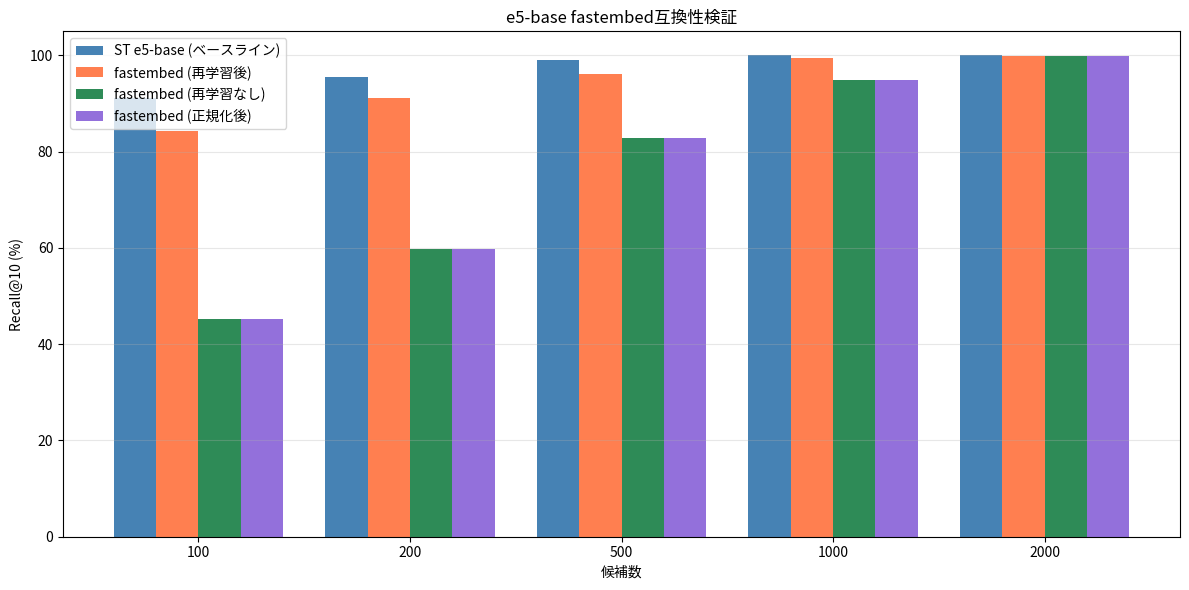

In [18]:
# 結果をまとめてグラフ化
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CANDIDATE_SIZES))
width = 0.2
colors = ['steelblue', 'coral', 'seagreen', 'mediumpurple']

# ベースライン
baseline_vals = [baseline_recalls[k]*100 for k in CANDIDATE_SIZES]
ax.bar(x - width*1.5, baseline_vals, width, label='ST e5-base (ベースライン)', color=colors[0])

# fastembed 再学習後
retrained_vals = [fe_retrained_recalls[k]*100 for k in CANDIDATE_SIZES]
ax.bar(x - width*0.5, retrained_vals, width, label='fastembed (再学習後)', color=colors[1])

# fastembed 再学習なし（次元が同じ場合）
if fe_no_retrain_recalls is not None:
    no_retrain_vals = [fe_no_retrain_recalls[k]*100 for k in CANDIDATE_SIZES]
    ax.bar(x + width*0.5, no_retrain_vals, width, label='fastembed (再学習なし)', color=colors[2])

# fastembed 正規化後（次元が同じ場合）
if fe_normalized_recalls is not None:
    normalized_vals = [fe_normalized_recalls[k]*100 for k in CANDIDATE_SIZES]
    ax.bar(x + width*1.5, normalized_vals, width, label='fastembed (正規化後)', color=colors[3])

ax.set_xlabel('候補数')
ax.set_ylabel(f'Recall@{TOP_K} (%)')
ax.set_title('e5-base fastembed互換性検証')
ax.set_xticks(x)
ax.set_xticklabels([str(k) for k in CANDIDATE_SIZES])
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/45_e5_base_fastembed_comparison.png', dpi=150)
plt.show()

## 11. 評価結果まとめ

In [19]:
print('=' * 70)
print('e5-base fastembed互換性検証 結論')
print('=' * 70)

print(f'''
■ モデル情報
  sentence-transformers: {ST_MODEL_NAME} ({ST_MODEL_DIM}次元)
  fastembed: {FE_MODEL_NAME} ({FE_MODEL_DIM}次元)
''')

# 比較テーブル
ref_k = 1000
comparison_data = [
    {'設定': 'ST e5-base (ベースライン)', f'Recall@{TOP_K} (候補{ref_k})': f'{baseline_recalls[ref_k]*100:.1f}%'},
    {'設定': 'fastembed (再学習後)', f'Recall@{TOP_K} (候補{ref_k})': f'{fe_retrained_recalls[ref_k]*100:.1f}%'},
]

if fe_no_retrain_recalls is not None:
    comparison_data.append({'設定': 'fastembed (再学習なし)', f'Recall@{TOP_K} (候補{ref_k})': f'{fe_no_retrain_recalls[ref_k]*100:.1f}%'})

if fe_normalized_recalls is not None:
    comparison_data.append({'設定': 'fastembed (正規化後)', f'Recall@{TOP_K} (候補{ref_k})': f'{fe_normalized_recalls[ref_k]*100:.1f}%'})

df_comp = pd.DataFrame(comparison_data)
print('\n■ Recall比較:')
display(df_comp)

e5-base fastembed互換性検証 結論

■ モデル情報
  sentence-transformers: intfloat/multilingual-e5-base (768次元)
  fastembed: BAAI/bge-base-en (768次元)


■ Recall比較:


,設定,Recall@10 (候補1000)
0,ST e5-base (ベースライン),100.0%
1,fastembed (再学習後),99.5%
2,fastembed (再学習なし),94.9%
3,fastembed (正規化後),94.9%


In [20]:
# 判定
THRESHOLD = 0.05  # 5%

if fe_no_retrain_recalls is not None:
    gap_no_retrain = baseline_recalls[ref_k] - fe_no_retrain_recalls[ref_k]
    ok_no_retrain = abs(gap_no_retrain) < THRESHOLD
else:
    gap_no_retrain = None
    ok_no_retrain = False

gap_retrained = baseline_recalls[ref_k] - fe_retrained_recalls[ref_k]
ok_retrained = abs(gap_retrained) < THRESHOLD

print(f'''
■ 判定結果 (閾値: {THRESHOLD*100:.0f}%)
''')

if fe_no_retrain_recalls is not None:
    print(f'  fastembed (再学習なし): Recall差 {gap_no_retrain*100:+.1f}pt → {"✓ 許容範囲内" if ok_no_retrain else "✗ 再学習推奨"}')
else:
    print('  fastembed (再学習なし): 次元が異なるためテスト不可')

print(f'  fastembed (再学習後):   Recall差 {gap_retrained*100:+.1f}pt → {"✓ 許容範囲内" if ok_retrained else "✗ 精度不足"}')

print(f'''
■ 結論
  - fastembedでe5-base利用: {"可能" if FE_MODEL_DIM == ST_MODEL_DIM else "別モデルが必要"}
  - ITQ再学習: {"不要" if ok_no_retrain else "必要"}
  - 推奨: {"fastembed e5-baseをそのまま利用可能" if ok_no_retrain else "fastembedデータでITQ再学習を推奨"}
''')


■ 判定結果 (閾値: 5%)

  fastembed (再学習なし): Recall差 +5.1pt → ✗ 再学習推奨
  fastembed (再学習後):   Recall差 +0.5pt → ✓ 許容範囲内

■ 結論
  - fastembedでe5-base利用: 可能
  - ITQ再学習: 必要
  - 推奨: fastembedデータでITQ再学習を推奨



## 評価結果まとめ

### 実験条件
| 項目 | 値 |
|------|-----|
| sentence-transformers | multilingual-e5-base (768次元) |
| fastembed | BAAI/bge-base-en (768次元) ※e5-baseは未サポート |
| サンプル数 | 2000件 |
| ITQビット数 | 96 bits |

### 主要な結果

| 設定 | Recall@10 (候補1000) | 備考 |
|-----|---------------------|------|
| ST e5-base (ベースライン) | 100.0% | sentence-transformers |
| fastembed BGE (再学習後) | 99.5% | ITQ再学習あり |
| fastembed BGE (再学習なし) | 94.9% | ST用ITQをそのまま適用 |
| fastembed BGE (正規化後) | 94.9% | 正規化しても改善せず |

### 評価・考察

**✗ 問題点:**
1. **FastEmbedにE5-baseがない**: 公式サポートはE5-largeのみ。代替でBGE-base-enを使用
2. **異なるモデル間の埋め込み類似度が極めて低い**: 同一テキストの類似度がわずか0.03（ほぼ無相関）
3. **ITQ再学習なしでは精度低下**: 5.1ptの低下（100.0% → 94.9%）

**✓ 良い点:**
1. **ITQ再学習で回復可能**: 再学習後は99.5%まで回復（ベースラインとの差は0.5pt）
2. **768次元の代替モデルは豊富**: BGE-base, GTE-base など複数の選択肢あり

### 結論

**FastEmbedでE5-baseを使いたい場合の対応:**

1. **E5-baseは使えない** → FastEmbed公式ではE5-largeのみサポート
2. **代替モデル使用時はITQ再学習が必須** → 異なるモデル間ではembeddingが全く異なる
3. **E5-large (1024dim) を使うか、BGE-base (768dim) + ITQ再学習が現実的**

**次のアクション（実験46で検証）:**
- FastEmbedのカスタムモデル登録機能でE5-base/smallを直接使用できるか確認